In [ ]:
!pip install annoy

Found 400 images belonging to 2 classes.
1/1 [==============================] - 0s 445ms/step


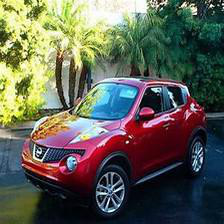

cars/115.jpg


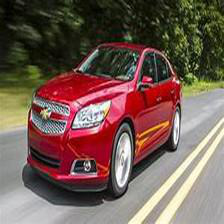

cars/174.jpg


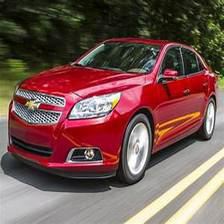

cars/182.jpg


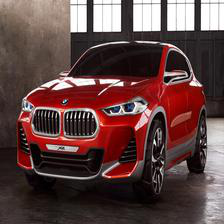

cars/53.jpg


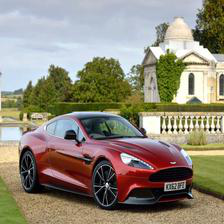

cars/15.jpg


In [4]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from annoy import AnnoyIndex

# Set the path to the folder containing the images
image_folder = "v_data/train/"

# Set the dimensions for resizing the images
image_size = (224, 224)

# Set the number of principal components to keep
n_components = 50

# Set the number of nearest neighbors to retrieve
n_neighbors = 5

# Create an ImageDataGenerator for loading and preprocessing images
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load the images from the directory
image_iterator = data_generator.flow_from_directory(
    image_folder,
    target_size=image_size,
    class_mode=None,
    shuffle=False,
    batch_size=1
)

# Create lists to store image embeddings and corresponding filenames
embeddings = []
filenames = []

# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Extract embeddings for each image in the directory
embeddings = model.predict(image_iterator)
filenames = image_iterator.filenames

# Perform PCA on the embeddings
pca = PCA(n_components=n_components)
pca_embeddings = pca.fit_transform(embeddings)

# Build the ANNOY index
annoy_index = AnnoyIndex(n_components, metric='euclidean')
for i, embedding in enumerate(pca_embeddings):
    annoy_index.add_item(i, embedding)
annoy_index.build(n_neighbors)


# Perform image similarity search
query_image_path = "sports_car.jpg"
query_image = Image.open(query_image_path).resize(image_size)
query_image = np.expand_dims(query_image, axis=0)
query_image = preprocess_input(query_image)
query_embedding = model.predict(query_image).flatten()
query_embedding_pca = pca.transform([query_embedding])

# Find the nearest neighbors using ANNOY
nearest_indices = annoy_index.get_nns_by_vector(query_embedding_pca[0], n_neighbors)


for index in nearest_indices:
    img = load_img(f"v_data/train/{filenames[index]}")
    display(img)
    print(filenames[index])
